In [27]:
# Component 4: K-Means Customer Segmentation 

# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load Excel file
df = pd.read_excel("Online_Retail.xlsx")

In [4]:
#Check data
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# 2. Prepare RFM dataset
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

if 'TotalAmount' not in df.columns:
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
# Filter invalid data
df = df[df['CustomerID'].notnull() & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['CustomerID'] = df['CustomerID'].astype(int)
df.shape

(397884, 9)

In [9]:
# Snapshot date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
})

rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalAmount':'Monetary'}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [10]:
# 3. Standardize data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled

array([[ 2.33457414e+00, -4.25096503e-01,  8.35866818e+00],
       [-9.05340320e-01,  3.54416797e-01,  2.50966264e-01],
       [-1.75359593e-01, -3.53398530e-02, -2.85960063e-02],
       ...,
       [-8.45341904e-01, -2.95177619e-01, -2.08742313e-01],
       [-8.85340848e-01,  1.52368675e+00,  4.51854273e-03],
       [-4.95351144e-01, -1.65258736e-01, -2.41412739e-02]])

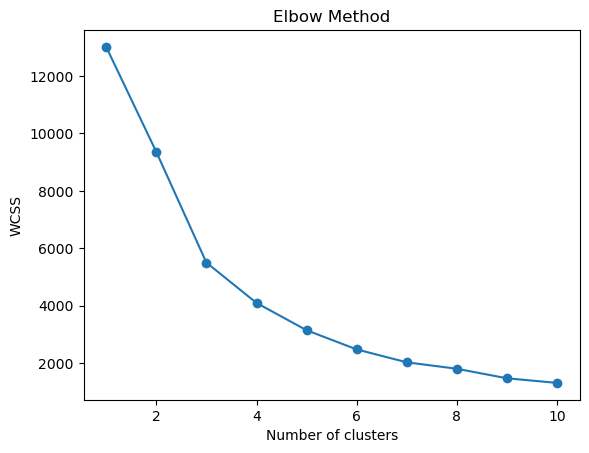

In [11]:
# 4. Elbow method 

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


In [15]:
# 5. K-Means clustering

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346,326,1,77183.60,1,Inactive
12347,2,7,4310.00,0,Occasional
12348,75,4,1797.24,0,Occasional
12349,19,1,1757.55,0,Occasional
12350,310,1,334.40,1,Inactive


In [13]:
# 6. Map descriptive labels 

cluster_labels = {}
cluster_mean = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
for i, row in cluster_mean.iterrows():
    if row['Recency'] > 100 and row['Frequency'] < 5:
        cluster_labels[i] = 'Inactive'
    elif row['Monetary'] > 5000 and row['Frequency'] > 50:
        cluster_labels[i] = 'Loyal'
    else:
        cluster_labels[i] = 'Occasional'

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

In [14]:
# 7. Summary table 

print("Counts per Segment:")
print(rfm['Segment'].value_counts())
print("\nMean RFM values per Segment:")
print(rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().round(1))

Counts per Segment:
Segment
Occasional    3231
Inactive      1093
Loyal           14
Name: count, dtype: int64

Mean RFM values per Segment:
            Recency  Frequency  Monetary
Segment                                 
Inactive      246.0        1.6     631.1
Loyal           7.1       80.2  122888.4
Occasional     41.0        4.9    2012.1


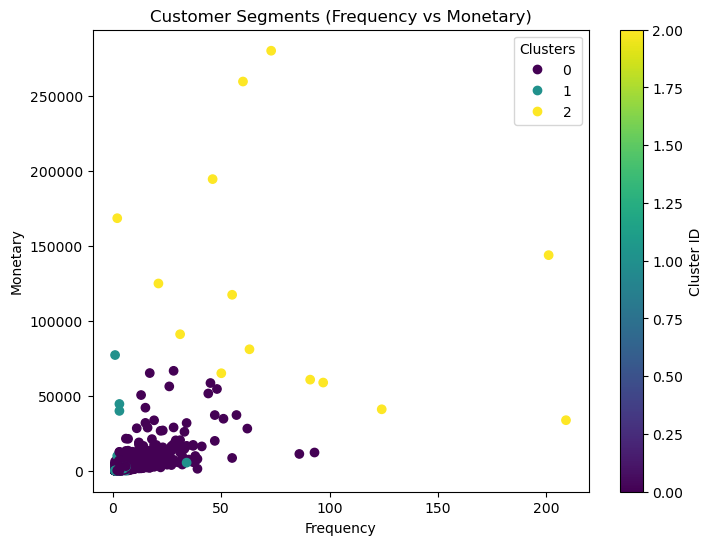

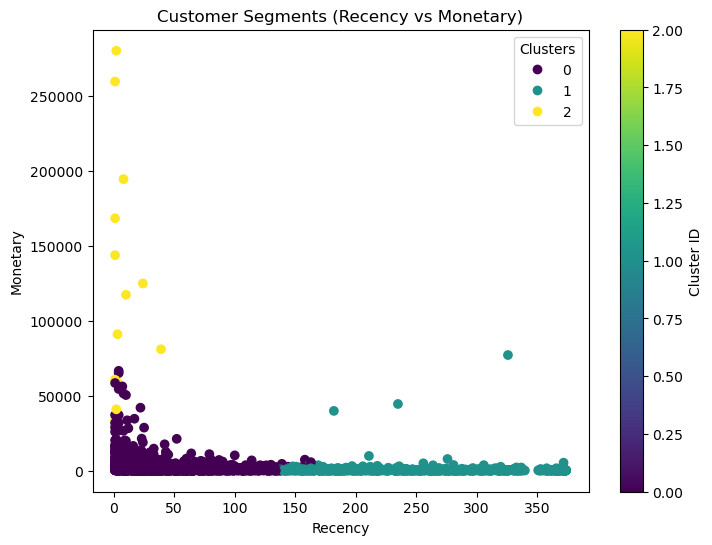

In [20]:
# 8. Scatter plots (same as original, no centroids, same colors)

plt.figure(figsize=(8,6))
scp=plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.legend(*scp.legend_elements(), title="Clusters")
plt.colorbar(label='Cluster ID') # Adds a legend for the colors
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments (Frequency vs Monetary)')
plt.show()

plt.figure(figsize=(8,6))
scp = plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.legend(*scp.legend_elements(), title="Clusters")
plt.colorbar(label='Cluster ID') # Adds a legend for the colors
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segments (Recency vs Monetary)')
plt.show()

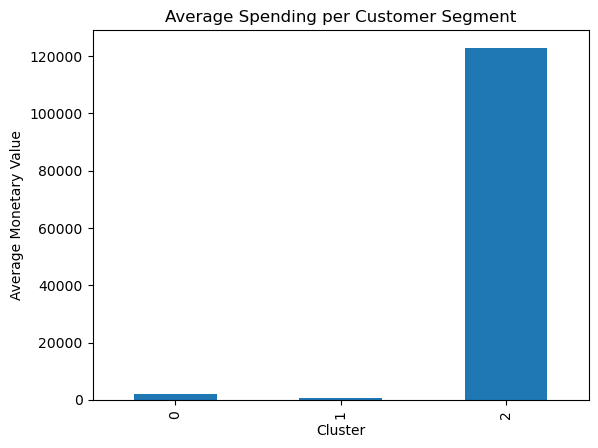

In [21]:
# 9. Bar plot: Average Monetary per Cluster (numeric clusters, same as before)

rfm.groupby('Cluster')['Monetary'].mean().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary Value')
plt.title('Average Spending per Customer Segment')
plt.show()

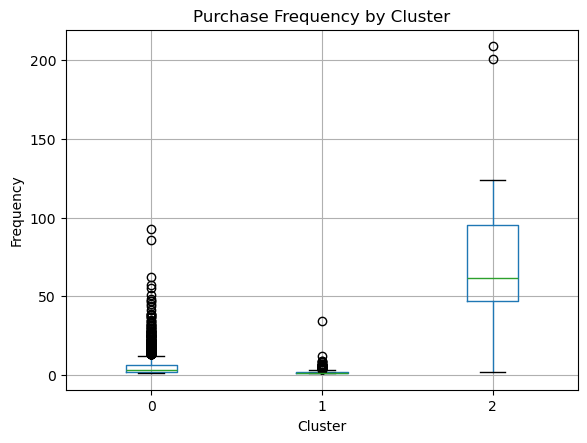

In [22]:
# 10. Boxplot: Frequency per Cluster (numeric clusters)
rfm.boxplot(column='Frequency', by='Cluster')
plt.title('Purchase Frequency by Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

In [23]:
# 11 Add the cluster labels as a new column to the original dataset.

df['Cluster'] = df['CustomerID'].map(rfm['Cluster'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1


In [24]:
#12 Group by the Cluster column and calculate statistics for RFM features
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std']
})

# Display the summary table
print(cluster_summary)

            Recency                    Frequency                    \
               mean median        std       mean median        std   
Cluster                                                              
0         40.983906   30.0  35.086788   4.852677    3.0   5.991890   
1        246.023788  241.0  67.436073   1.582800    1.0   1.449314   
2          7.142857    2.5  11.072191  80.214286   61.5  61.401802   

              Monetary                            
                  mean      median           std  
Cluster                                           
0          2012.111620     922.390   4093.853436  
1           631.141410     311.010   2998.396241  
2        122888.407143  104221.005  78384.562739  


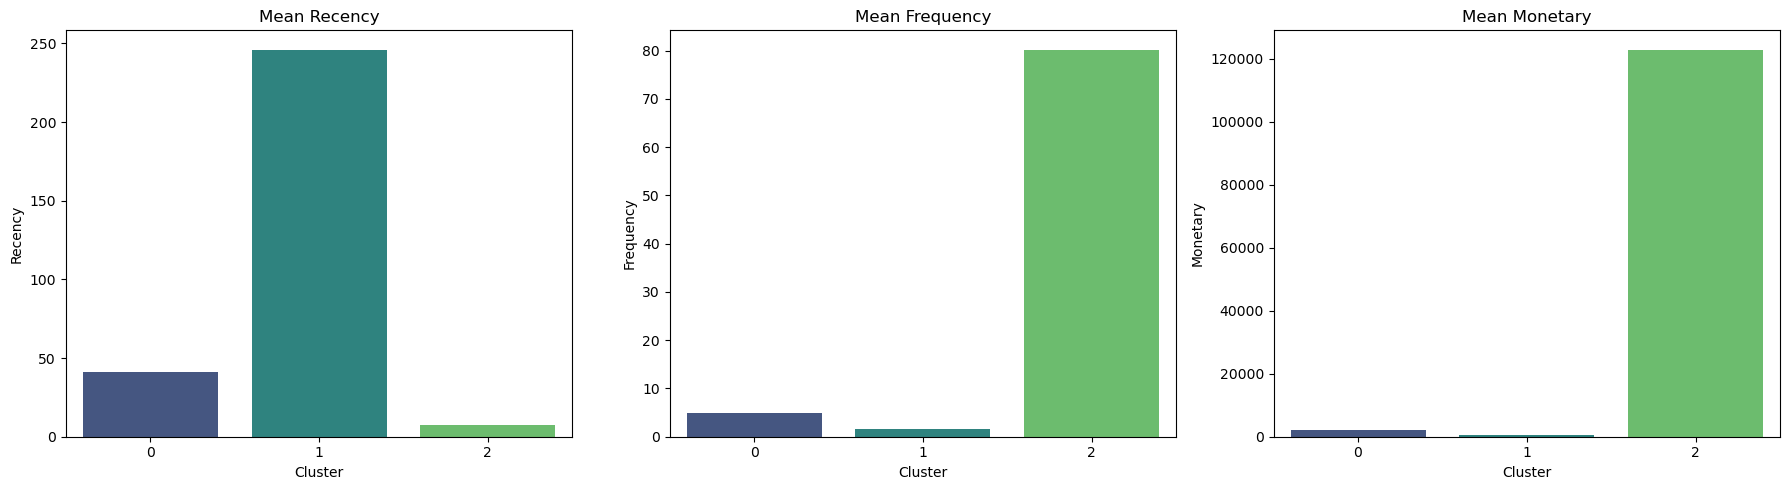

In [28]:
# First, calculate just the means for cleaner plotting
cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Set up a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Mean Recency
sns.barplot(data=cluster_means, x='Cluster', y='Recency', ax=axes[0], palette='viridis')
axes[0].set_title('Mean Recency')

# Plot Mean Frequency
sns.barplot(data=cluster_means, x='Cluster', y='Frequency', ax=axes[1], palette='viridis')
axes[1].set_title('Mean Frequency')

# Plot Mean Monetary
sns.barplot(data=cluster_means, x='Cluster', y='Monetary', ax=axes[2], palette='viridis')
axes[2].set_title('Mean Monetary')

plt.tight_layout()
plt.show()

In [29]:

# 1. Calculate the mean values for each cluster to use as a baseline
profiles = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# 2. Define a function to describe the profile based on RFM values
def describe_cluster(row):
    # These thresholds are examples; they compare the row to the overall average
    avg_r = rfm['Recency'].mean()
    avg_f = rfm['Frequency'].mean()
    avg_m = rfm['Monetary'].mean()
    
    if row['Recency'] < avg_r and row['Monetary'] > avg_m:
        return "VIP/Champions", "Frequent high-spenders who shopped recently. Highly loyal."
    elif row['Recency'] > avg_r and row['Monetary'] > avg_m:
        return "At-Risk/Whales", "Big spenders who haven't returned in a while. Need re-engagement."
    elif row['Recency'] < avg_r and row['Frequency'] < avg_f:
        return "New Customers", "Recent first-time shoppers with low spend. High potential."
    elif row['Recency'] > avg_r and row['Frequency'] < avg_f:
        return "Lost Customers", "Made a small purchase long ago and never returned."
    else:
        return "Steady Customers", "Average shoppers with predictable behavior."

# 3. Apply the profiling
profiles[['Segment Name', 'Description']] = profiles.apply(
    lambda x: pd.Series(describe_cluster(x)), axis=1
)

# Display the finalized profiles
print(profiles[['Cluster', 'Segment Name', 'Description']])


   Cluster      Segment Name  \
0        0  Steady Customers   
1        1    Lost Customers   
2        2     VIP/Champions   

                                         Description  
0        Average shoppers with predictable behavior.  
1  Made a small purchase long ago and never retur...  
2  Frequent high-spenders who shopped recently. H...  


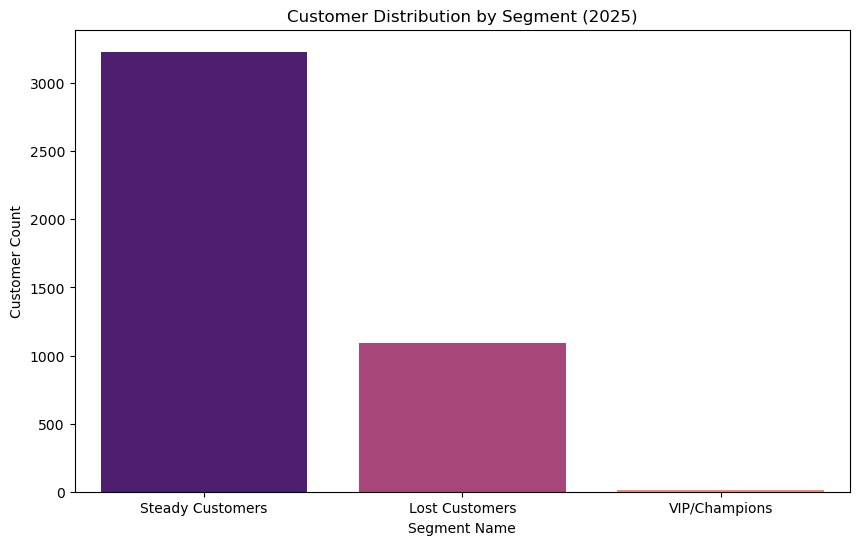

In [30]:

# Count how many customers are in each segment
segment_counts = rfm['Cluster'].value_counts().sort_index()
profiles['Customer Count'] = segment_counts.values

plt.figure(figsize=(10, 6))
sns.barplot(data=profiles, x='Segment Name', y='Customer Count', palette='magma')
plt.title('Customer Distribution by Segment (2025)')
plt.show()
